# 0.0. IMPORTS

In [1]:
import pandas as pd
import numpy  as np
#import pickle as pi
import inflection
import math
from IPython.display import Image
#import warnings
#
#from pandas.plotting       import scatter_matrix
#from pandas_profiling      import ProfileReport
#
import seaborn as sns
from matplotlib            import pyplot as plt
import matplotlib.patches as  mpatches
#from matplotlib.gridspec   import GridSpec
#import plotly.express as px
#import plotly.figure_factory as ff
#
from datetime import timedelta
import datetime 
#import re 
#
from scipy import stats
#import statsmodels.api as sm
#from iv                             import analise_iv as i
#from matplotlib.widgets             import Button
from IPython.core.display           import HTML
#from tabulate                       import tabulate
#
## Data preprocessing
#
from boruta import BorutaPy
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing          import RobustScaler, MinMaxScaler, LabelEncoder, OrdinalEncoder
#from sklearn.model_selection        import StratifiedShuffleSplit, StratifiedKFold, RepeatedStratifiedKFold
#from sklearn.model_selection        import cross_val_score, cross_validate, cross_val_predict
#from sklearn.model_selection        import train_test_split
#from sklearn.model_selection        import RandomizedSearchCV, GridSearchCV
#
## Machine leaarning models
#
#from sklearn.linear_model           import LogisticRegression
#
#
## Evaluating metrics
#
#from sklearn.metrics                import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score
#from sklern.metrics                 import confusion_matrix, precision_recall_curve
#
#
#warnings.filterwarnings('ignore')
#

## 0.1. Helper Functions

In [2]:
def cramer_v (x, y):
    cm = pd.crosstab( x, y).values
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = stats.chi2_contingency( cm )[0]
    chi2corr = max (0, chi2 - (k-1) * (r-1)/ (n-1))
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    
    return np.sqrt( (chi2corr/n) / (min (kcorr-1, rcorr-1)))

def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh')
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()
    
jupyter_settings()

#def jupyter_settings():
#    %matplotlib inline
#    %pylab inline
#    
#    plt.style.use( 'bmh' )
#    plt.rcParams['figure.figsize'] = [25, 12]
#    plt.rcParams['font.size'] = 24
#    
#    display( HTML( '<style>.container { width:100% !important; }</style>') )
#    pd.options.display.max_columns = None
#    pd.options.display.max_rows = None
#    pd.set_option( 'display.expand_frame_repr', False )
#    
#    sns.set()
#    
#jupyter_settings()


# Frequency table
def frequency(df, vars):
    if len(vars)> 0:
        c1 = df[vars[0]]
        c2 = []
        for i in range(1,len(vars)):
            c2.append(df[vars[i]])
            dfs = []
            dfs.append(pd.crosstab(c1,c2).unstack().reset_index().rename(columns={0: 'contagem'}))
            dfs.append(pd.crosstab(c1,c2, normalize='all').unstack().reset_index().rename(columns={0:'percent'}))
            dfs = [df.set_index(vars) for df in dfs]
            df = dfs[0].join(dfs[1:]).reset_index()
            return df 
        
# Outliers
def outliers(dataset, var):
    
    figure, gr = plt.subplots()
    
    gr.figure.set_size_inches(14,12)
    
    plt.subplot(2,1,1)
    gr = sns.histplot(dataset[var], bins=50)
    plt.xlabel(var, fontsize=14)
    plt.ylabel('Density', fontsize=14)
    
    plt.subplot(2,1,2)
    gr = sns.boxplot(dataset[var])
    plt.xlabel(var, fontsize=14)
    plt.show()
    
    # calculando Q1, Q3 and FIQ
    Q1 = dataset[var].quantile(0.25)
    Q3 = dataset[var].quantile(0.75)
    FIQ = Q3 - Q1
    
    # calculando o limite dos outliers
    min_outlier = Q1 - 1.5 * FIQ
    max_outlier = Q3 + 1.5 * FIQ
    
    print('Limites para outliers: ''\n')
    print(f'Q1 = {Q1}\nQ3 = {Q3}\nFIQ = {FIQ}\nmin_outlier = {min_outlier}\nmax_outlier = {max_outlier}')

# Coeficiente de determinação R²

def coef_r2(dataset, var_1, target):
    
    a = dataset[[var_1, target]]
    b = dataset[dataset[target]== 0]
    c = dataset[dataset[target]== 1]
    d = ((len(c)*c[var_1].var())+(len(b)*b[var_1].var()))/ len(a)
    e = a[var_1].var()
    
    r2 = 1 - (d/e)
    
    return r2


## Função feature selection
#
#def feature_selection(x_treino, y_treino):
#    rf = RandomForestClassifier(random_state=42)
#    rf.fit(x_treino, y_treino)
#    
#    feat_imp = pd.DataFrame({'Váriaveis': x_treino.columns,
#                            'Importância da Variável': rf.feature_importances_}).sort_values('Importância da Variável',
#                                                                                            ascending=False).reset_index(drop=True)
#    plt.subplot(figsize=(12,6))
#    sns.barplot(x='Importância da Variável',y='Váriaveis', data=feat_imp,orient='h',color='green')
#    plt.show()
#
## Função performance dados teste
#
#def performance_treino(x_treino, y_treino, x_teste, y_teste, modelo, nome_modelo):
#    #treinando modelo
#    modelo.fit(x_treino, y_treino)
#    
#    # Previsões do modelo 
#    
#    y_hat = modelo.predict(x_teste)
#    
#    # Métricas de performance
#    
#    acuracia = accuracy_score(y_teste, y_hat)
#    precisao = precision_score(y_teste,y_hat)
#    sensibilidade = recall_score(y_teste, y_hat)
#    f1 = f1_score(y_teste, y_hat)
#    
#    # Dataframe das métricas
#    
#    df_performance = pd.DataFrame({'Acurácia': acuracia,
#                                   'Precisão': precisao,
#                                   'Sensibilidade': sensibilidade,
#                                   'F1_score': f1}, index=[nome_modelo])
#    
#    # Matriz de confusão
#    cm = confusion_matrix (y_teste, y_hat)
#    
#    # Heatmap matriz de confusão
#    
#    df_cm = pd.DataFrame(cm)
#    
#    return df_performance, df_cm
#
## Função cross validation
#
#def validacao_cruzada(x, y, classificadores, nomes_classificadores):
#    
#    resultados = {}
#    
#    for i in range(len(classificadores)):
#        accs_vc = cross_validate(classificadores[i], x, y, cv=StratifiedKFold(n_splits=10),
#                                scoring = ['accuracy', 'precision', 'recall','f1'])
#        
#        acc = accs_vc['accuracy_test'].mean()
#        prec = accs_vc['precision_test'].mean()
#        sens = accs_vc['recall_test'].mean()
#        f1 = accs_vc['f1_test'].mean()
#        
#        resultados[nomes_classificadores[i]] = [acc,prec,sens,f1]
#        resultados = pd.DataFrame(resultados, index=['Acurácia', 'Precisão','Sensibilidade', 'F1-Score'])
#        
#        return resultados
#    
## Função ML + cross validation - dados de treino
#
#def machine_learning(classificadores, nomes_classificadores, x_treino, y_treino):
#     
#    for clf in classificadores:
#        print('Treinando modelos' + type(clf).__name__+ '...')
#       # treinando classificador
#        clf.fit(x_treino, y_treino)
#            
#        perfomance = validacao_cruzada(x_treino,y_treino,classificadores,nomes_classificadores)
#            
#    return perfomance.T 
#
## Matrizes de confusão
#
#def matrizes_confusao(modelos, x_treino,y_treino,linhas, colunas, a, b):
#    
#    # plot
#    fig, ax = plt.subplot(nrows = linhas, ncols = colunas, figsize=(a,b))
#    
#    for mod, ax, n in zip (range(len(modelos)), ax.flatten(), list(range(linhas*colunas))):
#        
#        plt.subplot(linhas, colunas, n+1)
#        
#        predicoes = cross_val_predict(modelos[mod], x_treino,y_treino, cv=StratifiedKFold(n_splits=10))
#        
#        cm - confusion_matrix(y_treino, predicoes)
#        
#        ax = sns.heatmap(cm, annot=True, fmt='g', cmap='viridis',
#                         square=True, annot_kws={'size': 14})
#        
#        plt.xlabel('Predict Value')
#        plt.ylabel('Real Value')
#        ax.title.set_text(type(modelos[mod]).__name__)
#    plt.tight_layout()
#    plt.show()
#    
## Função Hyperparameter finetunnig
#
#def hipertunagem( modelo,treino,target,tipo = 'grid', n_iter=20 ):
#    
#    validacao = RepeatedStratifiedKFold(n_splits=10, n_repeats=3)
#    
#    if tipo =='grid':
#        search = GridSearchCV(modelo, param_grid=parametros,
#                              scoring= 'f1', cv = validacao,
#                              n_iter=n_iter, verbose=1, n_jobs=-1)
#    
#    elif tipo == 'random':
#        search = RandomizedSearchCV(modelo, param_distributions=parametros,
#                                    scoring= 'f1', cv = validacao,
#                                    n_iter=n_iter, verbose=1, n_jobs=-1)
#    else:
#        print('Entrada invalida no argumento "tipo"')
#        
#    
#    search.fit(treino,target)
#    
#    estimadores = search.best_estimator_
#    
#    print('\nF1-Score: {:.4f}'.format(search.best_score_))
#    
#    print('Melhores parâmetros: {}\n'.format(search.best_params))
#    
#    return estimadores
#
#
## função performance dados de teste - possibilidade variação threshold
#
#def perfomance_teste1(nome_modelo,modelo, x_teste,y_teste, threshold):
#    
#    # predict
#    
#    y_hat = modelo.predict_proba(x_teste)
#    
#    #dataframe
#    
#    probs = pd.DataFrame(y_hat[:,1], columns=['probs'])
#    
#    # appling threshold
#    
#    y_hat = probs['probs'].apply(lambda x: 1 if x > threshold else 0)
#    
#    # Métricas de performance
#    
#    accuracy = accuracy_score(y_teste, y_hat)
#    precision  = precision_score(y_teste,y_hat)
#    recall = recall_score(y_teste, y_hat)
#    f1 = f1_score(y_teste, y_hat)
#    roc_auc = roc_auc_score(y_teste,y_hat)
#    
#    # Dataframe das métricas
#    
#    performance_df = pd.DataFrame({'Acurácia': acuracia,
#                                   'Precisão': precisao,
#                                   'Sensibilidade': sensibilidade,
#                                   'F1_score': f1,
#                                   'ROC AUC Score': roc_auc},index=[nome_modelo])
#    
#    # Matriz de confusão
#    cm = confusion_matrix (y_teste, y_hat)
#    
#    # Heatmap matriz de confusão
#    
#    cm_df = sns.heatmap(cm, annot=True,fmt='g', cmap='Greens',
#                        square=True, annot_kws={'size': 14})
#    
#        
#    return performance_df, cm_df

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


## 0.2. Loading data

In [3]:
df_sales_raw = pd.read_csv( 'train.csv', low_memory=False )
df_store_raw = pd.read_csv( 'store.csv', low_memory=False )

# merge
df_raw = pd.merge( df_sales_raw, df_store_raw, how='left', on='Store' )

In [5]:
#df_raw.head()

# 1.0 DESCRICAO DOS DADOS

In [4]:
df1 = df_raw.copy()

In [5]:
del df_raw

## 1.1. Rename Columns

In [6]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday', 
            'StoreType', 'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth',
            'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore( x )

cols_new = list( map( snakecase, cols_old ) )

# rename
df1.columns = cols_new

## 1.2. Data Dimensions

In [9]:
print( 'Number of Rows: {}'.format( df1.shape[0] ) )
print( 'Number of Cols: {}'.format( df1.shape[1] ) )

Number of Rows: 1017209
Number of Cols: 18


## 1.3. Data Types

In [10]:
df1['date'] = pd.to_datetime( df1['date'] )
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4. Check NA

In [11]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5. Fillout NA

In [12]:
#competition_distance
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else (x))

#competition_open_since_month
df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)

#competition_open_since_year
df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)

#promo2_since_week
df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis=1)

#promo2_since_year
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1)

#promo_interval 
month_map = {1: 'Jan',2: 'Feb',3: 'Mar',4: 'Apr',5: 'May',6: 'Jun',7: 'Jul',8: 'Aug',9: 'Sep',10: 'Oct',11: 'Nov',12: 'Dec'}

df1['promo_interval'].fillna(0, inplace=True)

df1['month_map'] = df1['date'].dt.month.map(month_map) 

df1['is_promo'] = df1[['promo_interval','month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1)



In [13]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

## 1.6. Change Data Types

In [14]:
# competiton
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype( 'int64' )
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype( 'int64' )
    
# promo2
df1['promo2_since_week'] = df1['promo2_since_week'].astype( 'int64' )
df1['promo2_since_year'] = df1['promo2_since_year'].astype( 'int64' )

## 1.7. Descriptive Statistics

In [15]:
num_attributes = df1.select_dtypes( include=['int64', 'float64'] )
cat_attributes = df1.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'] )

### 1.7.1. Numerical Atributes

In [16]:
# Central Tendency - mean, mediana 
#ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
#ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T
#
## dispersion - std, min, max, range, skew, kurtosis
#d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T 
#d2 = pd.DataFrame( num_attributes.apply( min ) ).T 
#d3 = pd.DataFrame( num_attributes.apply( max ) ).T 
#d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T 
#d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T 
#d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T 
#
## concatenar
#m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
#m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
#m

In [17]:
# Histograma da feature competition distance
#%matplotlib widget
#sns.histplot(data=df1, x='competition_distance', kde=True );

### 1.7.2. Categorical Atributes

In [18]:
#Qtda de valores únicos de cada feature categórica
#cat_attributes.apply( lambda x: x.unique().shape[0] )

In [19]:
# Boxplot de features categóricas em relação as vendas
#%matplotlib widget
#aux = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]
#
#plt.subplot( 1, 3, 1 )
#sns.boxplot( x='state_holiday', y='sales', data=aux )
#
#plt.subplot( 1, 3, 2 )
#sns.boxplot( x='store_type', y='sales', data=aux )
#
#plt.subplot( 1, 3, 3 )
#sns.boxplot( x='assortment', y='sales', data=aux );

In [20]:
#aux.head().T

# 2.0 FEATURE ENGINEERING

## 2.1. Mind Map Hypothesis

In [21]:
df2 = df1.copy()

In [22]:
del df1

In [23]:
#Image('images/DAILY_STORE_SALES_Mind_map_hip.png')

##  2.2. Criação das Hipóteses

### 2.2.1. Hipoteses de Loja

**H1.** Lojas com maior quadro de funcionarios deveriam vender mais.

**H2.** Lojas com maior estoque deveriam vender mais.

**H3.** Lojas com maior porte deveriam vender mais.

**H4.** Lojas com competidores a mais tempo deveriam vender mais.

**H5.** Lojas com maior sortimento deveriam vender mais.

**H6.** Lojas com competidores mais próximos deveriam vender mais.

### 2.2.2. Hipoteses de Produto

**H1.** Lojas que investem mais em marketing deveriam vender mais.

**H2.** Lojas que expoem mais os produtos nas vitrines deveriam vender mais.

**H3.** Lojas que tem preços menores deveriam vender mais.

**H4.** Lojas que tem preços menores por mais tempo deveriam vender mais.

**H5.** Lojas com promoções mais agressivas (maiores descontos), deveriam vender mais.

**H6.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**H7.** Lojas com mais dias de promoção devriam vender mais.

**H8.** Loja com mais promoções consecutivas deveriam vender mais.

### 2.2.3. Hipoteses de Tempo

**H1.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**H2.** Lojas deveriam vender mais ao longo dos anos.

**H3.** Lojas deveriam vender mais no segundo semestre do ano.

**H4.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**H5.** Lojas deveriam vender menos aos finais de semana.

**H6.** Lojas deveriam vender menos durante feriados escolares.

## 2.3. Lista final de Hipóteses

**H1.** Lojas com maior sortimento deveriam vender mais.

**H2.** Lojas com competidores mais próximos deveriam vender mais.

**H3.** Lojas com competidores a mais tempo deveriam vender mais.

**H4.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**H5.** Lojas com mais dias de promoção devriam vender mais.

**H6.** Loja com mais promoções consecutivas deveriam vender mais.

**H7.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**H8.** Lojas deveriam vender mais ao longo dos anos.

**H9.** Lojas deveriam vender mais no segundo semestre do ano.

**H10.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**H11.** Lojas deveriam vender menos aos finais de semana.

**H12.** Lojas deveriam vender menos durante feriados escolares.

## 2.4. Feature Engineering

In [24]:
 # year
df2['year'] = df2['date'].dt.year

 # Month
df2['month'] = df2['date'].dt.month

 # day
df2['day'] = df2['date'].dt.day

 # week of year
df2['week_of_year'] = df2['date'].dt.isocalendar().week.astype('int64') # estava como int32

 # year week
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

#competition since
df2['competition_since'] = df2.apply(lambda x: datetime.datetime( year=x['competition_open_since_year'],month=x['competition_open_since_month'],day=1), axis=1)
df2['competition_time_month'] = ((df2['date'] - df2['competition_since'])/30).apply(lambda x: x.days).astype( 'int64' )

#Promo since
df2['promo_since'] = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype( str )
df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w') - timedelta(days=7))
df2['promo_time_week'] = ((df2['date'] - df2['promo_since'])/ 7).apply( lambda x: x.days).astype('int64')

 #assortment
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended' )

# state holiday
df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day')

# 3.0. DATA FILTERING

In [25]:
df3 = df2.copy()

In [26]:
del df2

## 3.1. Filtragem de linhas 

In [27]:
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

## 3.2. Filtragem de colunas

In [28]:
cols_drop = ['customers','open','promo_interval','month_map']
df3 = df3.drop(cols_drop, axis=1)

In [29]:
df3.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'week_of_year', 'year_week', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_time_week'],
      dtype='object')

# 4.0. EXPLORATORY DATA ANALYSIS (EDA)

In [30]:
df4 = df3.copy()

In [31]:
del df3

## 4.1. Analise Univariada

### 4.1.1. Variável reposta

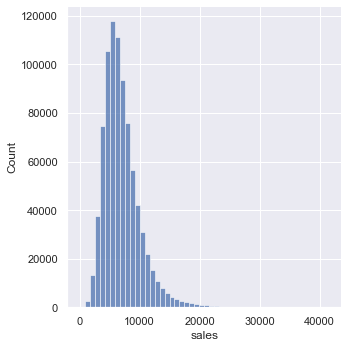

In [32]:
sns.displot(df4['sales'],kde=False, bins=50);

### 4.1.2. Variáveis numéricas

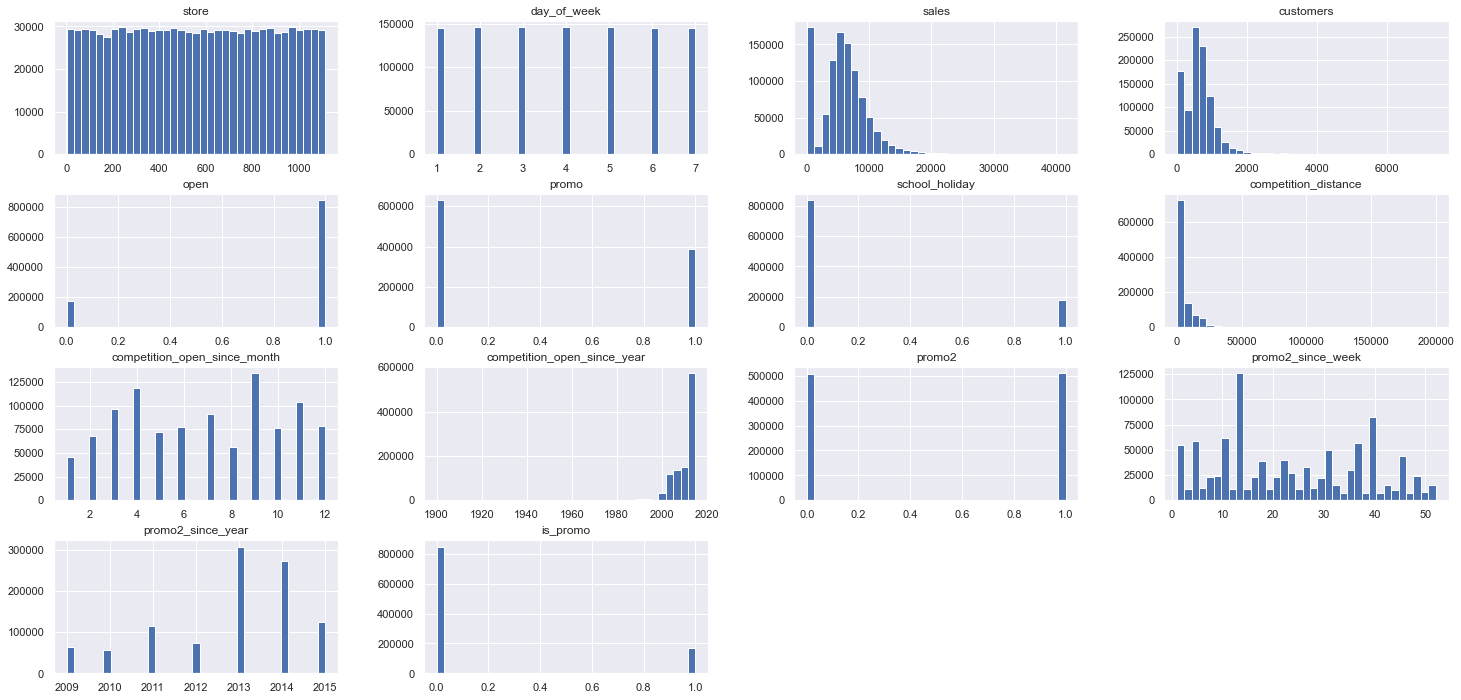

In [33]:
num_attributes.hist(bins=35);

### 4.1.3. Variáveis categóricas

In [34]:
#state_holiday
#df4['assortment'].drop_duplicates()

In [35]:
#state_holiday
#fig = plt.figure()
#ax = fig.add_subplot(3,2,1)
#ax = df4[df4['state_holiday']!= 'regular_day']
#sns.countplot(x=ax['state_holiday'])
#
#
#ax2 = fig.add_subplot(3,2,2)
#sns.kdeplot(df4[df4['state_holiday']== 'public_holiday']['sales'],shade=True, legend=True)
#sns.kdeplot(df4[df4['state_holiday']== 'easter_holiday']['sales'],shade=True, legend=True)
#sns.kdeplot(df4[df4['state_holiday']== 'christmas']['sales'],shade=True, legend=True)
#handles = [mpatches.Patch(facecolor=plt.cm.Reds(100),label='public_holiday'),
#            mpatches.Patch(facecolor=plt.cm.Blues(110),label='easter_holiday'),
#            mpatches.Patch(facecolor=plt.cm.Greens(120),label='christmas')]
#plt.legend(handles=handles)
#
#
### store_type
#ax3 = fig.add_subplot(3,2,3)
#sns.countplot(df4['store_type'])
#
#ax4 = fig.add_subplot(3,2,4)
#sns.kdeplot(df4[df4['store_type']== 'a']['sales'],shade=True, legend=True)
#sns.kdeplot(df4[df4['store_type']== 'b']['sales'],shade=True, legend=True)
#sns.kdeplot(df4[df4['store_type']== 'c']['sales'],shade=True, legend=True)
#sns.kdeplot(df4[df4['store_type']== 'd']['sales'],shade=True, legend=True)
#handles = [mpatches.Patch(facecolor=plt.cm.Reds(100),label='a'),
#            mpatches.Patch(facecolor=plt.cm.Blues(110),label='b'),
#            mpatches.Patch(facecolor=plt.cm.Greens(120),label='c'),
#            mpatches.Patch(facecolor=plt.cm.Greens(120),label='d')]
#plt.legend(handles=handles)
#
#
## assortment
#ax5 = fig.add_subplot(3,2,5)
#sns.countplot(df4['assortment'])
#
#
#ax6 = fig.add_subplot(3,2,6)
#sns.kdeplot(df4[df4['assortment']== 'basic']['sales'],shade=True, legend=True)
#sns.kdeplot(df4[df4['assortment']== 'extended']['sales'],shade=True, legend=True)
#sns.kdeplot(df4[df4['assortment']== 'extra']['sales'],shade=True, legend=True)
#handles = [mpatches.Patch(facecolor=plt.cm.Reds(100),label='basic'),
#            mpatches.Patch(facecolor=plt.cm.Blues(110),label='extended'),
#            mpatches.Patch(facecolor=plt.cm.Greens(120),label='extra')
#            ]
#plt.legend(handles=handles)
#plt.show();
#

## 4.2. Analise Bivariada

### **H1.** Lojas com maior sortimento deveriam vender mais. **False**(Lojas com maior sortimento vendem menos)

In [36]:
#aux1 = df4[['assortment', 'sales']].groupby('assortment').sum().reset_index()
#sns.barplot(x='assortment',y='sales',data=aux1)
#plt.show()
#
#fig = plt.figure()
#ax7 = fig.add_subplot(2,1,1)
#aux2 = df4[['year_week','assortment', 'sales']].groupby(['year_week','assortment']).sum().reset_index()
#aux2.pivot(index='year_week',columns='assortment', values='sales').plot()
#plt.show()
#
#ax8 = fig.add_subplot(2,1,2)
#aux3 = aux2[aux2['assortment'] == 'extra']
#aux3.pivot(index='year_week',columns='assortment', values='sales').plot()
#plt.show();
#

### **H2.** Lojas com competidores mais próximos deveriam vender menos.
**False** Lojas com competidores mais proximos vendem mais

In [37]:
#aux11 = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index().sort_values(by='competition_distance',ascending=False)
#fig = plt.figure()
#ax10 = fig.add_subplot(1,3,1)
#sns.scatterplot(x='competition_distance',y='sales', data=aux11)
#
#
#ax11 = fig.add_subplot(1,3,2)
#bins = list(np.arange(0, 20000, 1000))
#aux11['competition_distance_binned'] = pd.cut(aux11['competition_distance'], bins=bins)
#aux12 = aux11[['competition_distance_binned', 'sales']].groupby('competition_distance_binned').sum().reset_index()
#sns.barplot(x='competition_distance_binned',y='sales',data=aux12)
#plt.xticks(rotation=90)
#
#
#ax12 = fig.add_subplot(1,3,3)
#sns.heatmap(aux11.corr(method='pearson'),annot=True)
#
#plt.show();

### **H3.** Lojas com competidores a mais tempo deveriam vender mais.
**False** Lojas com competidores a mais tempo vendem menos.

In [38]:
#fig = plt.figure()
#
#ax13 = fig.add_subplot(1,3,1)
#aux13 = df4[['competition_time_month','sales']].groupby('competition_time_month').sum().reset_index()
#aux14 = aux13[(aux13['competition_time_month']< 90) & (aux13['competition_time_month']!= 0)]
#sns.barplot(x='competition_time_month',y='sales',data=aux14)
#plt.xticks(rotation = 90);
#
#ax14 = fig.add_subplot(1,3,2)
#sns.regplot(x='competition_time_month',y='sales',data=aux14)
#
#ax15 = fig.add_subplot(1,3,3)
#sns.heatmap(aux13.corr(method='pearson'),annot=True)
#plt.show();

### **H4.** Lojas com promoções ativas por mais tempo deveriam vender mais.
**False** porque lojas com promoções ativas vendem menos depois de um certo periodo de promoção.

In [39]:
#fig = plt.figure()
#
##ax15 = fig.add_subplot(3,2,1)
#aux1 = df4[['promo_time_week','sales']].groupby('promo_time_week').sum().reset_index()
##sns.barplot(x='promo_time_week',y='sales',data=aux1)
#
#grid = GridSpec(2,3)
#
#ax15 = fig.add_subplot(grid[0,0])
#aux2 = aux1[aux1['promo_time_week'] > 0] # promo extendida
#sns.barplot(x='promo_time_week',y='sales',data=aux2)
#plt.xticks(rotation=90)
#
#ax16 = fig.add_subplot(grid[0,1])
#sns.regplot(x='promo_time_week',y='sales',data=aux2)
#
#ax17 = fig.add_subplot(grid[1,0])
#aux3 = aux1[aux1['promo_time_week'] < 0] # promo regular
#sns.barplot(x='promo_time_week',y='sales',data=aux3)
#plt.xticks(rotation=90)
#
#ax18 = fig.add_subplot(grid[1,1])
#sns.regplot(x='promo_time_week',y='sales',data=aux3)
#
#ax19 = fig.add_subplot(grid[:,2])
#sns.heatmap(aux1.corr(method='pearson'),annot=True)
#
#plt.show();

### <s> **H5.** Lojas com mais dias de promoção deveriam vender mais.<s/

In [40]:
#fig = plt.figure()
#pr = df4.loc[df4['promo_time_week'] > 0]
#axj = pr[['promo_time_week','sales']].groupby('promo_time_week').sum().reset_index().sort_values(by='sales',ascending=False)
#sns.lineplot(data=axj, x='promo_time_week', y='sales') 
#plt.show();

### **H6.** Loja com mais promoções consecutivas deveriam vender mais.
**False** Lojas com mais promoções consecutivas vendem menos

In [41]:
#fig = plt.figure()
#axk = (df4[(df4['promo'] == 1) & (df4['promo2'] == 1)][['year_week','sales']].groupby(['year_week']).sum().reset_index())
#plot1 = axk.plot()
#
#axk2 = (df4[(df4['promo'] == 1) & (df4['promo2'] == 0)][['year_week','sales']].groupby(['year_week']).sum().reset_index())
#axk2.plot(ax=plot1)
#
#plt.legend(labels=['Tradicional + Extendido', 'Extendido'])

### **H7.** Lojas abertas durante o feriado de Natal deveriam vender mais.
**False** LOjas abertas durante o natal vendem menos

In [42]:
#fig = plt.figure()
#
#axp = df4[df4['state_holiday']!= 'regular_day']
#plt.subplot(1, 2, 1)
#axz = axp[['state_holiday','sales']].groupby('state_holiday').sum().reset_index()
#sns.barplot(data=axz,x='state_holiday',y='sales')
#
#plt.subplot(1, 2, 2)
#axs = axp[['state_holiday','year','sales']].groupby(['year','state_holiday']).sum().reset_index()
#sns.barplot(data=axs,x='year',y='sales',hue='state_holiday')

### **H8.** Lojas deveriam vender mais ao longo dos anos.
**False** Lojas vendem menos ao longo dos anos.

In [43]:
#fig = plt.figure()
#
#axd = df4[['year','sales']].groupby('year').sum().reset_index()
#
#plt.subplot(1,3,1)
#sns.barplot(data=axd,x='year',y='sales')
#
#plt.subplot(1,3,2)
#sns.regplot(data=axd,x='year',y='sales')
#
#plt.subplot(1,3,3)
#sns.heatmap(axd.corr(method='pearson'), annot=True)
#

### **H9.** Lojas deveriam vender mais no segundo semestre do ano.
**False** Lojas vendem menos a partir do segundo semestre do ano.

In [44]:
#fig = plt.figure()
#
#axd = df4[['month','sales']].groupby('month').sum().reset_index()
#
#plt.subplot(1,3,1)
#sns.barplot(data=axd,x='month',y='sales')
#
#plt.subplot(1,3,2)
#sns.regplot(data=axd,x='month',y='sales')
#
#plt.subplot(1,3,3)
#sns.heatmap(axd.corr(method='pearson'), annot=True)
#

### **H10.** Lojas deveriam vender mais depois do dia 10 de cada mês.
**True** Lojas vendem mais depois do dia 10 de cada mes.

In [45]:
#fig = plt.figure()
#
#axd = df4[['day','sales']].groupby('day').sum().reset_index()
#
#plt.subplot(2,2,1)
#sns.barplot(data=axd,x='day',y='sales')
#
#plt.subplot(2,2,2)
#sns.regplot(data=axd,x='day',y='sales')
#
#plt.subplot(2,2,3)
#sns.heatmap(axd.corr(method='pearson'), annot=True)
#
#axd ['before_after'] = axd['day'].apply(lambda x: 'before_10' if x <= 10 else 'after_10')
#axd2 = axd[['before_after','sales']].groupby('before_after').sum().reset_index()
#plt.subplot(2,2,4)
#sns.barplot(data=axd2,x='before_after',y='sales')
#

### **H11.** Lojas deveriam vender menos aos finais de semana.
**True** Lojas vendem menos aos finais de semana.

In [46]:
#fig = plt.figure()
#
#axd = df4[['day_of_week','sales']].groupby('day_of_week').sum().reset_index()
#
#plt.subplot(1,3,1)
#sns.barplot(data=axd,x='day_of_week',y='sales')
#
#plt.subplot(1,3,2)
#sns.regplot(data=axd,x='day_of_week',y='sales')
#
#plt.subplot(1,3,3)
#sns.heatmap(axd.corr(method='pearson'), annot=True)
#

### **H12.** Lojas deveriam vender menos durante feriados escolares.
**True** Lojas vendem menos durante feriados escolares.(exceto mês de agosto)

In [47]:
#fig = plt.figure()
#
#axc = df4[['school_holiday', 'sales']].groupby('school_holiday').sum().reset_index()
#plt.subplot(2,1,1)
#sns.barplot(x= 'school_holiday',y='sales',data= axc)
#
#
#axc2 = df4[['month','school_holiday', 'sales']].groupby(['month','school_holiday']).sum().reset_index()
#plt.subplot(2,1,2)
#sns.barplot(x= 'month',y='sales',hue='school_holiday',data= axc2)

## 4.3. Analise Multivariada

### 4.3.1 Atributos numéricos

In [48]:
#fig = plt.figure()
#correlation = num_attributes.corr(method= 'pearson')
#sns.heatmap(correlation, annot=True);

### 4.3.2 Atributos categóricos

In [49]:
# categorical variables only
#a = df4.select_dtypes(include='object')

In [50]:
# Cramer's v dataset created
#a1 = cramer_v(a['state_holiday'],a['state_holiday'])
#a2 = cramer_v(a['state_holiday'],a['store_type'])
#a3 = cramer_v(a['state_holiday'],a['assortment'])
#
#a4 = cramer_v(a['store_type'],a['state_holiday'])
#a5 = cramer_v(a['store_type'],a['store_type'])
#a6 = cramer_v(a['store_type'],a['assortment'])
#
#a7 = cramer_v(a['assortment'],a['state_holiday'])
#a8 = cramer_v(a['assortment'],a['store_type'])
#a9 = cramer_v(a['assortment'],a['assortment'])
#
#cramer = pd.DataFrame ({'state_holiday': [a1, a2, a3],
#               'store_type': [a3, a4, a5],
#               'assortment': [a6, a7, a8]
#
#})
#
#cramer = cramer.set_index(cramer.columns)

In [51]:
# Cramer's correlation from categorical variables
#fig = plt.figure()
#sns.heatmap(cramer, annot=True)
#plt.show()

# 5.0. DATA PREPARATION

In [52]:
df5 = df4.copy()

## 5.1. Normalization

#### There's no variables with gaussian distribution so I skipped this step.

## 5.2. Rescaling

In [53]:
rs = RobustScaler()
mms = MinMaxScaler()

# competition distance 
df5['competition_distance'] = rs.fit_transform(df5['competition_distance'].values.reshape(-1,1) )
# competition time month
df5['competition_time_month'] = rs.fit_transform(df5['competition_time_month'].values.reshape(-1,1) )
## promo time week
df5['promo_time_week'] = mms.fit_transform(df5['promo_time_week'].values.reshape(-1,1) )
## year
df5['year'] = mms.fit_transform(df5['year'].values.reshape(-1,1) )

## 5.3 Transformation

### 5.3.1 Encoding

In [54]:
# state_holiday - One hot encoding (dummie)
df5 = pd.get_dummies(df5,prefix=['state_holiday'],columns=['state_holiday'])

# store_type - label encoding
le = LabelEncoder()
df5['store_type'] = le.fit_transform(df5['store_type'])

# assortment - Ordinal Encoding
assortment_dict = {'basic': 1, 'extra': 2, 'extended': 3 }
df5['assortment'] = df5['assortment'].map(assortment_dict)

### 5.3.2 Response variable transform

In [55]:
df5['sales'] = np.log1p(df5['sales'])

### 5.3.3 Nature transform

In [56]:
# month
df5['month_sin'] = df5['month'].apply(lambda x: np.sin(x * (2. * np.pi/ 12)))
df5['month_cos'] = df5['month'].apply(lambda x: np.cos(x * (2. * np.pi/ 12)))

# day
df5['day_sin'] = df5['day'].apply(lambda x: np.sin(x * (2. * np.pi/ 30)))
df5['day_cos'] = df5['day'].apply(lambda x: np.cos(x * (2. * np.pi/ 30)))

# day_of_week
df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin(x * (2. * np.pi/ 7)))
df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos(x * (2. * np.pi/ 7)))

# week of year
df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin(x * (2. * np.pi/ 52)))
df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos(x * (2. * np.pi/ 52)))

In [57]:
df5.head()

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,state_holiday_christmas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day,month_sin,month_cos,day_sin,day_cos,day_of_week_sin,day_of_week_cos,week_of_year_sin,week_of_year_cos
0,1,5,2015-07-31,8.568646,1,1,2,1,-0.170968,9,2008,0,31,2015,0,1.0,7,31,31,2015-30,2008-09-01,0.918919,2015-07-27,0.287016,0,0,0,1,-0.5,-0.866025,0.207912,0.978148,-0.974928,-0.222521,-0.568065,-0.822984
1,2,5,2015-07-31,8.710290,1,1,0,1,-0.283871,11,2007,1,13,2010,1,1.0,7,31,31,2015-30,2007-11-01,1.054054,2010-03-22,0.922551,0,0,0,1,-0.5,-0.866025,0.207912,0.978148,-0.974928,-0.222521,-0.568065,-0.822984
2,3,5,2015-07-31,9.025816,1,1,0,1,1.903226,12,2006,1,14,2011,1,1.0,7,31,31,2015-30,2006-12-01,1.202703,2011-03-28,0.801822,0,0,0,1,-0.5,-0.866025,0.207912,0.978148,-0.974928,-0.222521,-0.568065,-0.822984
3,4,5,2015-07-31,9.546527,1,1,2,3,-0.275806,9,2009,0,31,2015,0,1.0,7,31,31,2015-30,2009-09-01,0.743243,2015-07-27,0.287016,0,0,0,1,-0.5,-0.866025,0.207912,0.978148,-0.974928,-0.222521,-0.568065,-0.822984
4,5,5,2015-07-31,8.481151,1,1,0,1,4.448387,4,2015,0,31,2015,0,1.0,7,31,31,2015-30,2015-04-01,-0.162162,2015-07-27,0.287016,0,0,0,1,-0.5,-0.866025,0.207912,0.978148,-0.974928,-0.222521,-0.568065,-0.822984


# 6.0. FEATURE SELECTION

In [58]:
df6 = df5.copy()

In [59]:
del df5 

### 6.1. Split train test

In [60]:
cols_drop = ['week_of_year', 'day', 'month', 'day_of_week', 'promo_since','competition_since','year_week']
df6 = df6.drop(cols_drop, axis= 1)

In [61]:
df6[['store','date']].groupby('store').max().reset_index()['date'][0] - datetime.timedelta(days=7*6)

Timestamp('2015-06-19 00:00:00')

In [62]:
# train and test datasets
X_train = df6[df6['date'] < '2015-06-19']
y_train = X_train['sales']

X_test = df6[df6['date'] >= '2015-06-19']
y_test = X_test['sales']

print('Train Min. Date: {}'.format(X_train['date'].min()))
print('Train Max. Date: {}'.format(X_train['date'].max()))

print('\nTest Min. Date: {}'.format(X_test['date'].min()))
print('Test Max. Date: {}'.format(X_test['date'].max()))

Train Min. Date: 2013-01-01 00:00:00
Train Max. Date: 2015-06-18 00:00:00

Test Min. Date: 2015-06-19 00:00:00
Test Max. Date: 2015-07-31 00:00:00


### 6.2. Boruta as feature selector

In [63]:
# training test for boruta
#X_train_n = X_train.drop(['date','sales'], axis=1).values
#y_train_n = y_train.values.ravel()


# define random forest 
#rf = RandomForestRegressor ( n_jobs= -1)


#boruta = BorutaPy( rf, n_estimators= 'auto', verbose= 2, random_state= 42).fit( X_train_n,y_train_n)

In [71]:
cols_selected = boruta.support_.tolist()

# best features from boruta
X_train_fs = X_train.drop(['date','sales'], axis= 1)
cols_selected_boruta = X_train_fs.iloc[:,cols_selected].columns.to_list()

cols_not_selected_boruta = list(np.setdiff1d(X_train_fs.columns, cols_selected_boruta ))

NameError: name 'boruta' is not defined

### 6.3. Manual feature selection

In [67]:
cols_selected_boruta = ['store',
                        'promo',
                        'store_type',
                        'assortment',
                        'competition_distance',
                        'competition_open_since_month',
                        'competition_open_since_year',
                        'promo2',
                        'promo2_since_week',
                        'promo2_since_year',
                        'competition_time_month',
                        'promo_time_week',
                        'month_sin'
                        'month_cos',
                        'day_sin',
                        'day_cos',
                        'day_of_week_sin',
                        'day_of_week_cos',
                        'week_of_year_sin'
                        'week_of_year_cos']


# columns to add
feat_to_add = ['date','sales']

#final features

#cols_selected_boruta.extend(feat_to_add)

In [68]:
cols_selected_boruta

['store',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'competition_time_month',
 'promo_time_week',
 'month_sinmonth_cos',
 'day_sin',
 'day_cos',
 'day_of_week_sin',
 'day_of_week_cos',
 'week_of_year_sinweek_of_year_cos']

# 7.0. MACHINE LEARNING MODELLING

### 7.1. Average model

In [69]:
x_train = X_train[cols_selected_boruta]
x_test = X_test[cols_selected_boruta]

KeyError: "['month_sinmonth_cos', 'week_of_year_sinweek_of_year_cos'] not in index"

### 7.2. Linear Regression Model

### 7.3. Linear Regression Regularized Model